In [1379]:
import os
os.environ["OMP_NUM_THREADS"] = '1'
import win32gui,win32con,win32com,win32api
from PIL import Image, ImageGrab
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np

In [1380]:
def get_window_pos(name):
    handle = win32gui.FindWindow(0, name)
    return None if handle==0 else win32gui.GetWindowRect(handle), handle

def grab_screen(position):
    return ImageGrab.grab(position)
game_window_img = grab_screen(get_window_pos('大家来找茬')[0])

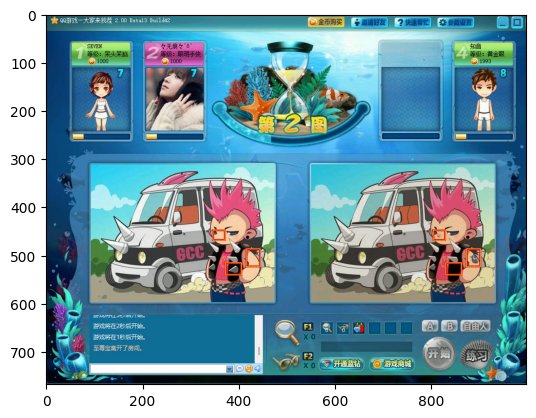

In [1381]:
test_img = plt.imread('./test.jpg')
plt.imshow(test_img)

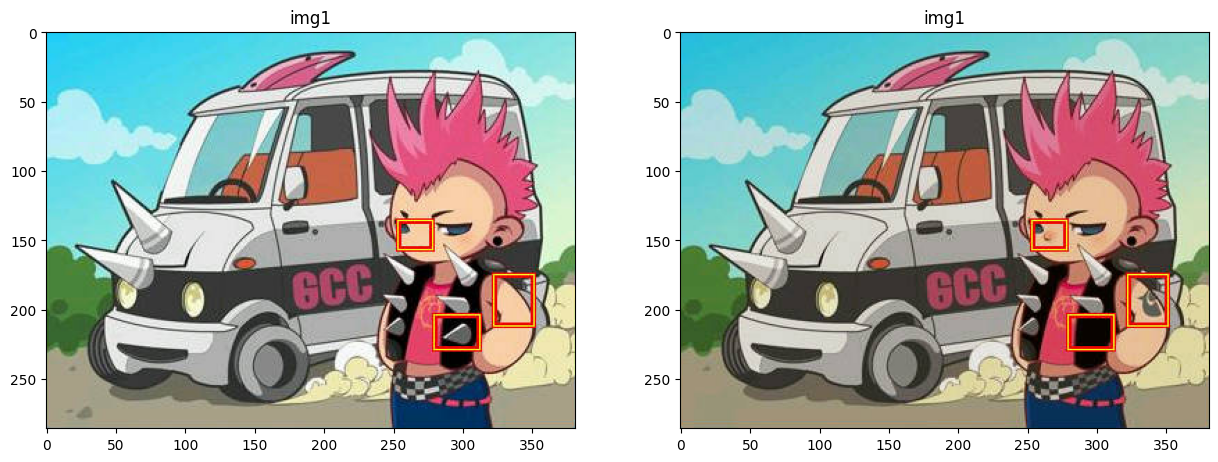

In [1382]:
IMG1_TOP = 312
IMG1_BOTTOM = 598
IMG1_LEFT = 93
IMG1_RIGHT = 474
IMG2_OFFSET = IMG1_RIGHT-IMG1_LEFT+76
img1 = test_img[IMG1_TOP:IMG1_BOTTOM,IMG1_LEFT:IMG1_RIGHT,:]
img2 = test_img[IMG1_TOP:IMG1_BOTTOM,IMG1_LEFT+IMG2_OFFSET:IMG1_RIGHT+IMG2_OFFSET,:]


plt.figure(figsize=(15,15))
plt.subplot(121)
plt.title('img1')
plt.imshow(img1)
plt.subplot(122)
plt.title('img1')
plt.imshow(img2)
plt.show()

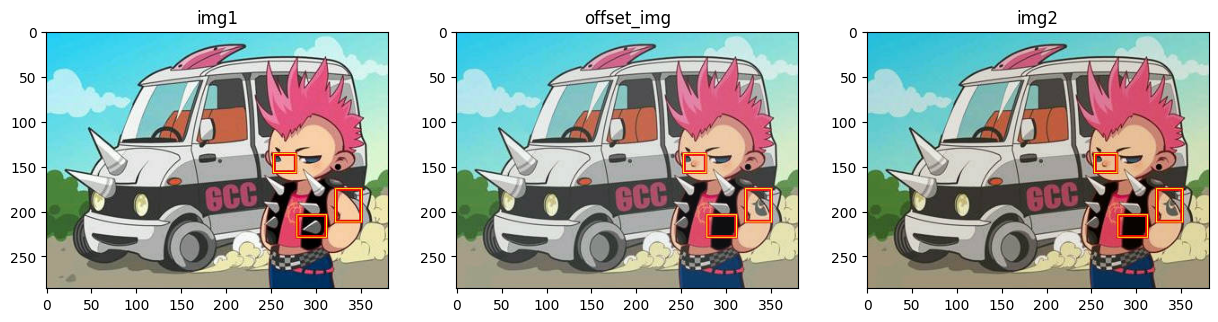

In [1383]:
offset = img1.mean(0).mean(0) - img2.mean(0).mean(0)
offset_img = np.zeros(img1.shape)
offset_img[:,:,0] = offset[0]
offset_img[:,:,1] = offset[1]
offset_img[:,:,2] = offset[2]
offset_img = offset_img.astype(np.uint8)
offset_img = cv.add(img2,offset_img)

# offset_img = np.repeat((img1.mean(2)-img2.mean(2)).reshape((286, 381,1)),3,2).astype(np.uint8)
# offset_mean = cv.add(img2,offset_img)

# offset = np.zeros(img1.shape)
# offset = (offset+16).astype(np.uint8)
# offset_img = cv.add(img2,offset)

plt.figure(figsize=(15,15))
plt.subplot(131)
plt.title('img1')
plt.imshow(img1)
plt.subplot(132)
plt.title('offset_img')
plt.imshow(offset_img)
plt.subplot(133)
plt.title('img2')
plt.imshow(img2)
plt.show()

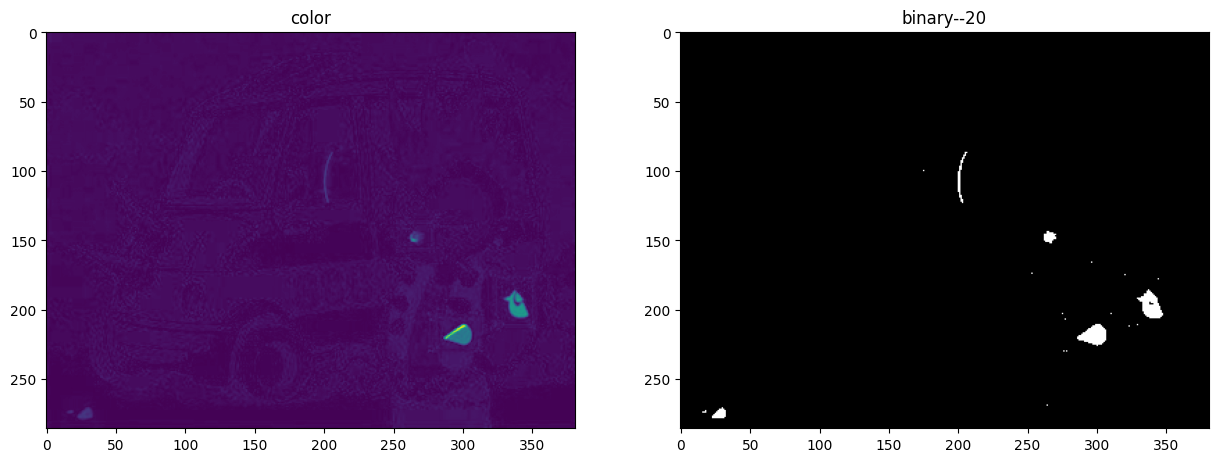

In [1384]:
img2 = offset_img
img1_bgr = cv.cvtColor(img1,cv.COLOR_RGB2BGR)
img2_bgr = cv.cvtColor(img2,cv.COLOR_RGB2BGR)
img1_blur = cv.blur(img1_bgr,(2,2)).astype(np.int16)
img2_blur = cv.blur(img2_bgr,(2,2)).astype(np.int16)
newimg = abs(img2_blur-img1_blur).astype(np.uint8)
newimg = cv.cvtColor(newimg,cv.COLOR_BGR2GRAY)
newimg = newimg.astype(np.uint8)
ret,thresh = cv.threshold(newimg,20,1,cv.THRESH_BINARY)#阈值设置为25 大于该阈值设置为1
# thresh = cv.adaptiveThreshold(newimg, 1, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, 11, 2)

plt.figure(figsize=(15,15))
plt.subplot(121)
plt.title('color')
plt.imshow(newimg)
plt.subplot(122)
plt.title('binary--20')
plt.imshow(thresh,cmap='gray')

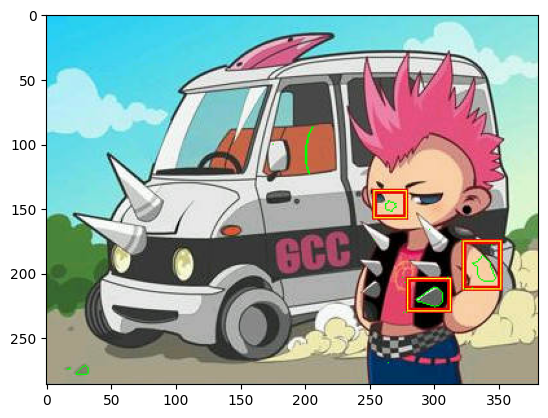

In [1385]:
"""
Parameter2------
RETR_EXTERNAL：仅仅检测外圈轮廓
RETR_LIST：检测所有轮廓，但是没有层级关系
RETR_CCOMP：仅仅两层包含关系，即只有外层和内层，假设有夹层，那么夹层也算外层，只要某个轮廓还包含有轮廓，都算外部轮廓
RETR_TREE：检测所有的轮廓，并建议非常完整的层级关系
RETR_FLOODFILL：无描述

Parameter3------
CHAIN_APPROX_NONE：相邻的轮廓点坐标只相差一个像素，所以是连续轮廓点
CHAIN_APPROX_SIMPLE：横、竖、对角线段只保存断点数据，比如矩形就只保存四个顶点。
"""
contours, hierarchy = cv.findContours(thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
contours = sorted(list(contours),key = lambda x:cv.contourArea(x),reverse=True)
nimg = cv.drawContours(img1, contours, -1, (0,255,0), 1)
plt.imshow(nimg)

# 通过Kmeans将周围的细小的分散区域进行聚类

In [1386]:
km = KMeans(n_clusters=5,n_init=20)
data = np.vstack(contours)
dataShape = data.shape
data = data.reshape((dataShape[0],dataShape[2]))
km.fit(data)

KMeans(n_clusters=5, n_init=20)

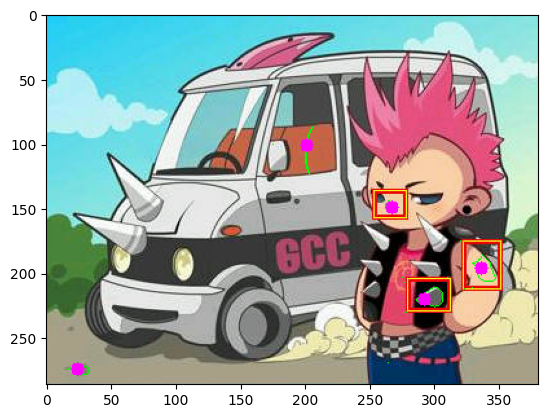

In [1387]:
for x,y in km.cluster_centers_:
    cv.circle(nimg,(int(x),int(y)),5,(255,0,255,),-1)
plt.imshow(nimg)